In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Load as module

In [6]:
from TracerFit import mwfit, int_idx

In [19]:
run_id=6
size = 110000
file = "sample_1m"

model_full = mwfit(sf_bool=False, perr_bool=False)
model_full.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_full_{run_id:03d}.h')

model_sf = mwfit(sf_bool=False, perr_bool=False)
model_sf.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sfast_{run_id:03d}.h')

model_sf_perr = mwfit(sf_bool=False, perr_bool=False)
model_sf_perr.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id:03d}.h')

In [10]:
for ii in range(5):
    print(model_full.optimize_results['lnp']['full_bfgs'][ii])
    for j in range(3):
        print(model_full.optimize_results['x']['full_bfgs'][ii][j*4:(j+1)*4])
    print(model_full.optimize_results['x']['full_bfgs'][ii][-2:], end='\n\n')

1023751.5031097434
[10.56058218  3.62565396  2.78038308  0.04434652]
[ 3.13811772  3.04317152  0.89128487 -0.74494932]
[11.02338846 -0.25609112  5.40494412 -0.57330362]
[-1.91408085 -1.21523016]

1011389.246455795
[ 8.92575502  0.8806284   0.78724814 -0.29281167]
[ 7.25125485 -3.48669996  0.8695709   0.95080685]
[11.51429828  0.53848295  9.2879311  -0.69610921]
[-2.12438928 -1.88768319]

1021507.2813769442
[ 9.84560077  0.97779831  3.1009531  -0.35347834]
[10.3404405   2.71491037  8.44086347 -0.42322548]
[10.57062459 -0.58871344  8.33557062 -0.23588591]
[-2.18818376 -1.79378928]

1023750.9087614163
[10.5710186   4.27751396  2.78167255  0.04545063]
[ 3.27810275 -1.60714843  2.75319813 -0.89185794]
[11.01675169 -0.26473662  5.38965075 -0.57993631]
[-1.91422091 -1.21569155]

1024065.421360327
[ 9.71335746  0.74546752  2.72233226 -0.08807937]
[10.30308641 -0.84750725  6.12776825 -0.14585608]
[10.8881795  -0.39321407  5.28223803 -0.63617616]
[-1.90811736 -1.19921971]



In [11]:
for ii in range(5):
    print(model_sf_perr.optimize_results['lnp']['sf_perr_bfgs'][ii])
    for j in range(3):
        print(model_sf_perr.optimize_results['x']['sf_perr_bfgs'][ii][j*4:(j+1)*4])
    print(model_sf_perr.optimize_results['x']['sf_perr_bfgs'][ii][-2:], end='\n\n')

206665.39486381435
[ 9.5309978   0.15106933  4.54170337 -1.82490076]
[-0.19843769  3.32753347  3.29533117  2.420339  ]
[1.12186711e+01 5.51711315e+00 4.12793836e+00 7.46948444e-08]
[-1.92338981 -1.17983043]

207062.171927135
[9.86775427 0.8469566  2.5966823  0.100784  ]
[10.78252778  0.5649514   5.31775852 -0.59956736]
[10.21657056 -1.28396586  2.0410349   3.        ]
[-1.79073678 -0.74954722]

213725.7900466386
[9.01765836 0.06945607 2.86817027 0.204316  ]
[10.34646566 -1.03391828  7.8102297  -5.        ]
[ 18.96861975 -10.          -1.16216271  -5.        ]
[-1.46242809 -0.51158309]

206958.5607330379
[10.25996014  1.40533505  2.72451476  0.07733993]
[ 6.73725616  4.58701147  0.33248139 -0.36339036]
[11.09749338  0.32713698  7.69728992 -5.        ]
[-1.93066582 -1.19154649]

206957.92607738383
[10.16316213  1.1683984   2.65260677  0.04549713]
[ 5.90794337 -0.23193216  1.97459289 -2.45109436]
[1.11426905e+01 5.28909692e-01 5.14347612e+00 4.98315976e-08]
[-1.89725048 -1.10215185]



# Load data

In [20]:
# Load Sample
sample = {}; true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample_1m.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], model_full.sample['source_id'], return_indices=True)[1]
    #subset = np.arange(len(hf['sample']['source_id'][...]))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=len(sample['source_id'])
    
# Apply Gaia Selection Function
sample['gaiasf_subset'] = sf_utils.apply_gaiasf(sample['l'], np.arcsin(sample['sinb']), sample['m'])[0]

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.156 s
  auxilliary:   4.153 s
          sf:   0.002 s
interpolator:   0.001 s


In [22]:
model_full._generate_fid_pars()
model_full.sample=sample

model_sf._generate_fid_pars()
model_sf.sample=sample

model_sf_perr._generate_fid_pars()
model_sf_perr.sample=sample

In [75]:
model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'] = \
model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'][model_sf_perr.mcmc_results['lnprob']['sf_perr_mcmc'][:,1000] > 0]

# Plot results

In [23]:
true_params_f = model_full.transform_params(model_full.get_true_params(true_pars))

(10.0, 40000)

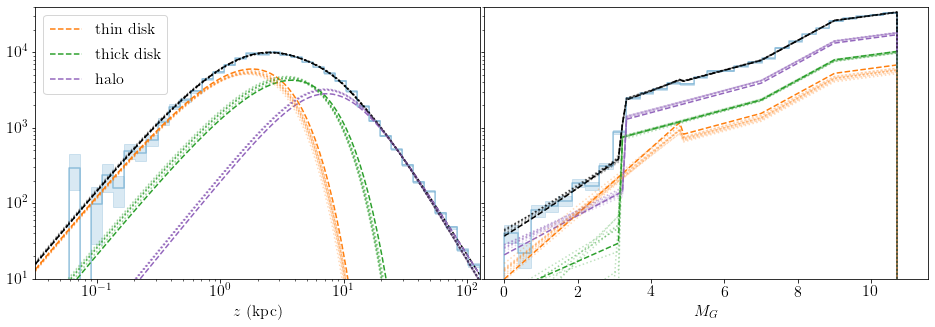

In [16]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

parameters = true_params_f.copy()

mcmc_samples = 10
nwalker, nstep, ndim = model_full.mcmc_results['chain']['full_mcmc'].shape
flat_chain = model_full.mcmc_results['chain']['full_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

true_kwargs = ({'c':'k','alpha':1, 'linestyle':'--'}, 
               {'c':'tab:orange','alpha':1, 'linestyle':'--', 'label':'thin disk'}, 
               {'c':'tab:green','alpha':1, 'linestyle':'--', 'label':'thick disk'}, 
               {'c':'tab:purple','alpha':1, 'linestyle':'--', 'label':'halo'})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})

plt.sca(axes[0])
zlim = (-1.5,2.1)
z_arr = np.logspace(zlim[0],zlim[1],101)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_parameters, fid_pars=model_full.fid_pars), **true_kwargs[0])
plotting.plot_hist(model_full.sample['s']*model_full.sample['sinb'], np.logspace(zlim[0],zlim[1],41), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

components = dh_msto.z_model(z_arr, parameters, fid_pars=model_full.fid_pars, model='all')
for i in range(3): axes[0].plot(z_arr, components[:,i], **true_kwargs[i+1]) 
    
for mcmc_sample in mcmc_samples:
    axes[0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model_full.fid_pars), **mcmc_kwargs[0])
    
    components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model_full.fid_pars, model='all')
    for i in range(3): axes[0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 
    
plt.xscale('log')
plt.xlim(10**zlim[0],10**zlim[1])
plt.legend()

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_parameters, fid_pars=model_full.fid_pars), **true_kwargs[0])
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})


components = dh_msto.M_model(M_arr, parameters, fid_pars=model_full.fid_pars, model='all')
for i in range(3): axes[1].plot(M_arr, components[:,i], **true_kwargs[i+1])
    
for mcmc_sample in mcmc_samples:
    axes[1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model_full.fid_pars), **mcmc_kwargs[0])
    
    components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model_full.fid_pars, model='all')
    for i in range(3): axes[1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 

plt.yscale('log'); plt.xlabel(r'$M_G$')
        
plt.subplots_adjust(wspace=0.01)

plt.ylim(10.,40000)

(10.0, 30000)

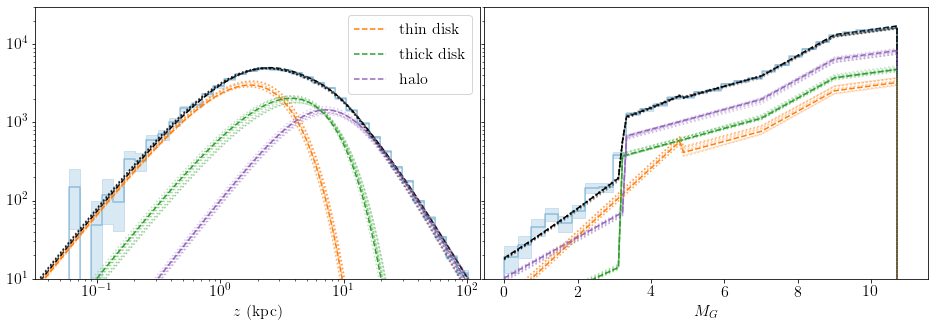

In [79]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

true_parameters = true_params_f.copy()

mcmc_samples = 10
nwalker, nstep, ndim = model.mcmc_results['chain']['sf_mcmc'].shape
flat_chain = model.mcmc_results['chain']['sf_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

true_kwargs = ({'c':'k','alpha':1, 'linestyle':'--'}, 
               {'c':'tab:orange','alpha':1, 'linestyle':'--', 'label':'thin disk'}, 
               {'c':'tab:green','alpha':1, 'linestyle':'--', 'label':'thick disk'}, 
               {'c':'tab:purple','alpha':1, 'linestyle':'--', 'label':'halo'})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})

plt.sca(axes[0])
zlim = (-1.5,2.1)
z_arr = np.logspace(zlim[0],zlim[1],101)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
plotting.plot_hist(model.sample['s']*model.sample['sinb'], np.logspace(zlim[0],zlim[1],41), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

components = dh_msto.z_model(z_arr, parameters, fid_pars=model.fid_pars, model='all')
for i in range(3): axes[0].plot(z_arr, components[:,i], **true_kwargs[i+1]) 
    
for mcmc_sample in mcmc_samples:
    axes[0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])
    
    components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 
    
plt.xscale('log')
plt.xlim(10**zlim[0],10**zlim[1])
plt.legend()

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})


components = dh_msto.M_model(M_arr, parameters, fid_pars=model.fid_pars, model='all')
for i in range(3): axes[1].plot(M_arr, components[:,i], **true_kwargs[i+1])
    
for mcmc_sample in mcmc_samples:
    axes[1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])
    
    components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 

plt.yscale('log'); plt.xlabel(r'$M_G$')
        
plt.subplots_adjust(wspace=0.01)

plt.ylim(10.,30000)

In [12]:
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

(10.0, 40000)

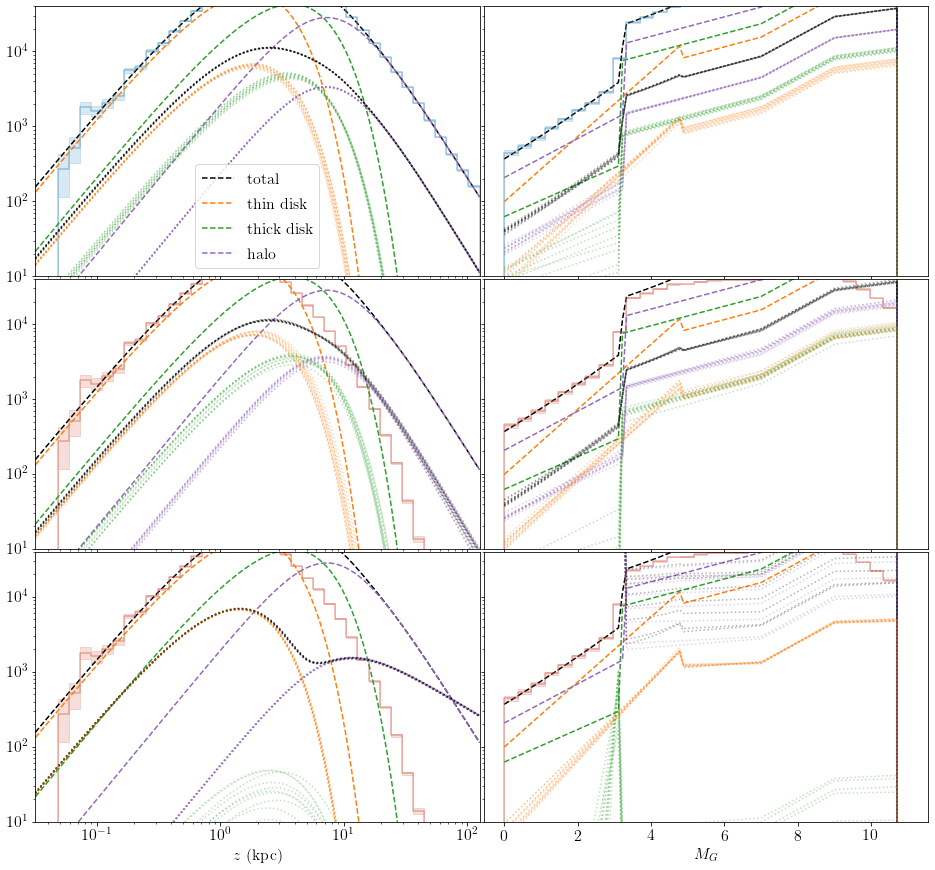

In [17]:
fig, axes = plt.subplots(3,2,figsize=(16,15), sharey=True, sharex='col')

true_parameters = true_params_f.copy()

true_kwargs = ({'c':'k','alpha':1, 'linestyle':'--', 'label':'total'}, 
               {'c':'tab:orange','alpha':1, 'linestyle':'--', 'label':'thin disk'}, 
               {'c':'tab:green','alpha':1, 'linestyle':'--', 'label':'thick disk'}, 
               {'c':'tab:purple','alpha':1, 'linestyle':'--', 'label':'halo'})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})


labels = ['full_mcmc', 'sf_mcmc', 'sf_perr_mcmc']
for jj, model in enumerate([model_full, model_sf, model_sf_perr]):

    nwalker, nstep, ndim = model.mcmc_results['chain'][labels[jj]].shape
    flat_chain = model.mcmc_results['chain'][labels[jj]][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.1)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
    if jj==0:
        plotting.plot_hist(model.sample['s']*model.sample['sinb'], np.logspace(zlim[0],zlim[1],41), ax=axes[jj,0], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
    else:
        plotting.plot_hist((model.sample['s']*model.sample['sinb'])[model.sample['gaiasf_subset']], 
                       np.logspace(zlim[0],zlim[1],41), ax=axes[jj,0], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.2), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.2})

    components = dh_msto.z_model(z_arr, true_params_f, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **true_kwargs[i+1]) 

    for mcmc_sample in mcmc_samples:
        axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])

        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
        for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 

    plt.xlim(10**zlim[0],10**zlim[1])
    if jj==0: plt.legend()

    plt.sca(axes[jj,1])
    M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                              np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                        true_pars['Mms2']])))
    axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
    
    if jj==0: 
        plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[jj,1], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
    else:
        plotting.plot_hist(sample['M'][sample['gaiasf_subset']], np.linspace(0,true_pars['Mx'],30), ax=axes[jj,1], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.2), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.2})

    components = dh_msto.M_model(M_arr, true_params_f, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **true_kwargs[i+1])

    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])

        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 


plt.sca(axes[2,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[2,1]); plt.yscale('log'); plt.xlabel(r'$M_G$')
        
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.ylim(10.,40000)#100000000)

#plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_zM_disthist.png', bbox_inches='tight', dpi=200)

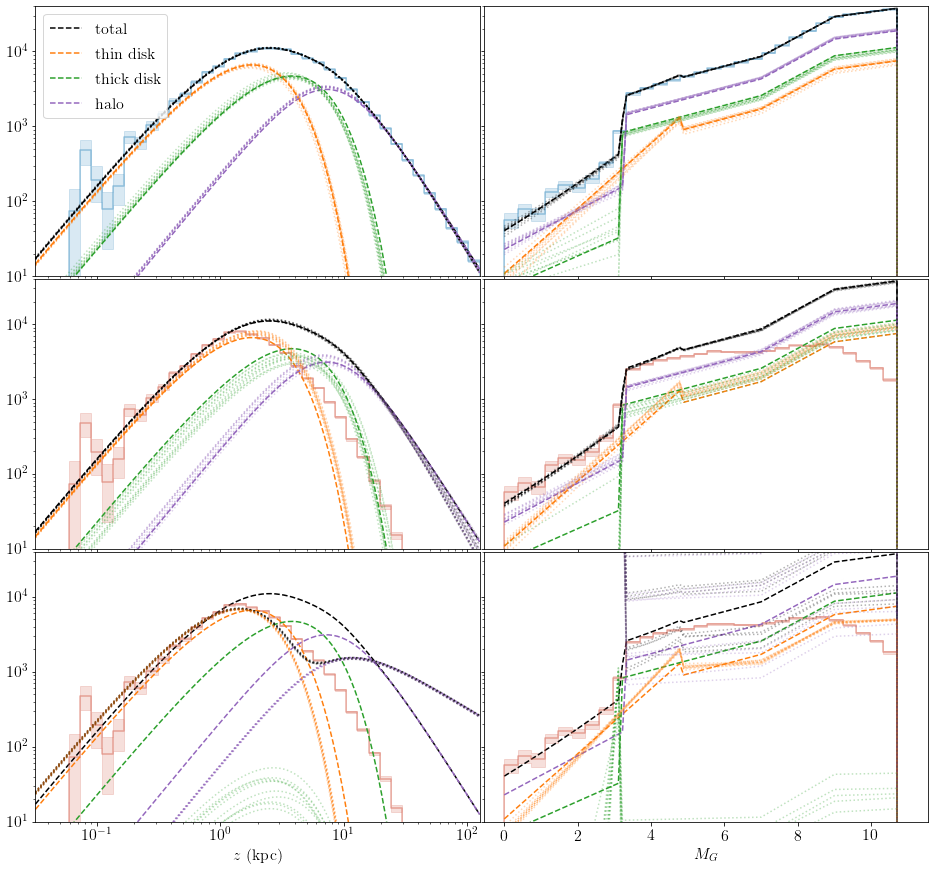

In [25]:
fig, axes = plt.subplots(3,2,figsize=(16,15), sharey=True, sharex='col')

true_parameters = true_params_f.copy()

true_kwargs = ({'c':'k','alpha':1, 'linestyle':'--', 'label':'total'}, 
               {'c':'tab:orange','alpha':1, 'linestyle':'--', 'label':'thin disk'}, 
               {'c':'tab:green','alpha':1, 'linestyle':'--', 'label':'thick disk'}, 
               {'c':'tab:purple','alpha':1, 'linestyle':'--', 'label':'halo'})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})


labels = ['full_mcmc', 'sf_mcmc', 'sf_perr_mcmc']
for jj, model in enumerate([model_full, model_sf, model_sf_perr]):

    nwalker, nstep, ndim = model.mcmc_results['chain'][labels[jj]].shape
    flat_chain = model.mcmc_results['chain'][labels[jj]][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.1)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
    if jj==0:
        plotting.plot_hist(model.sample['s']*model.sample['sinb'], np.logspace(zlim[0],zlim[1],41), ax=axes[jj,0], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
    else:
        plotting.plot_hist((model.sample['s']*model.sample['sinb'])[model.sample['gaiasf_subset']], 
                       np.logspace(zlim[0],zlim[1],41), ax=axes[jj,0], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.2), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.2})

    components = dh_msto.z_model(z_arr, true_params_f, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **true_kwargs[i+1]) 

    for mcmc_sample in mcmc_samples:
        axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])

        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
        for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 

    plt.xlim(10**zlim[0],10**zlim[1])
    if jj==0: plt.legend()

    plt.sca(axes[jj,1])
    M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                              np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                        true_pars['Mms2']])))
    axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
    
    if jj==0: 
        plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[jj,1], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
    else:
        plotting.plot_hist(sample['M'][sample['gaiasf_subset']], np.linspace(0,true_pars['Mx'],30), ax=axes[jj,1], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.2), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.2})

    components = dh_msto.M_model(M_arr, true_params_f, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **true_kwargs[i+1])

    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])

        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 


plt.sca(axes[2,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[2,1]); plt.yscale('log'); plt.xlabel(r'$M_G$')
        
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.ylim(10.,40000)#100000000)

plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_zM_disthist.png', bbox_inches='tight', dpi=200)

In [26]:
plt.rc('axes', labelsize=ndim*3)
plt.rc('xtick',labelsize=ndim*3)
plt.rc('ytick',labelsize=ndim*3)
plt.rc('legend',fontsize=ndim*4)
plt.rc('font',size=ndim*3)

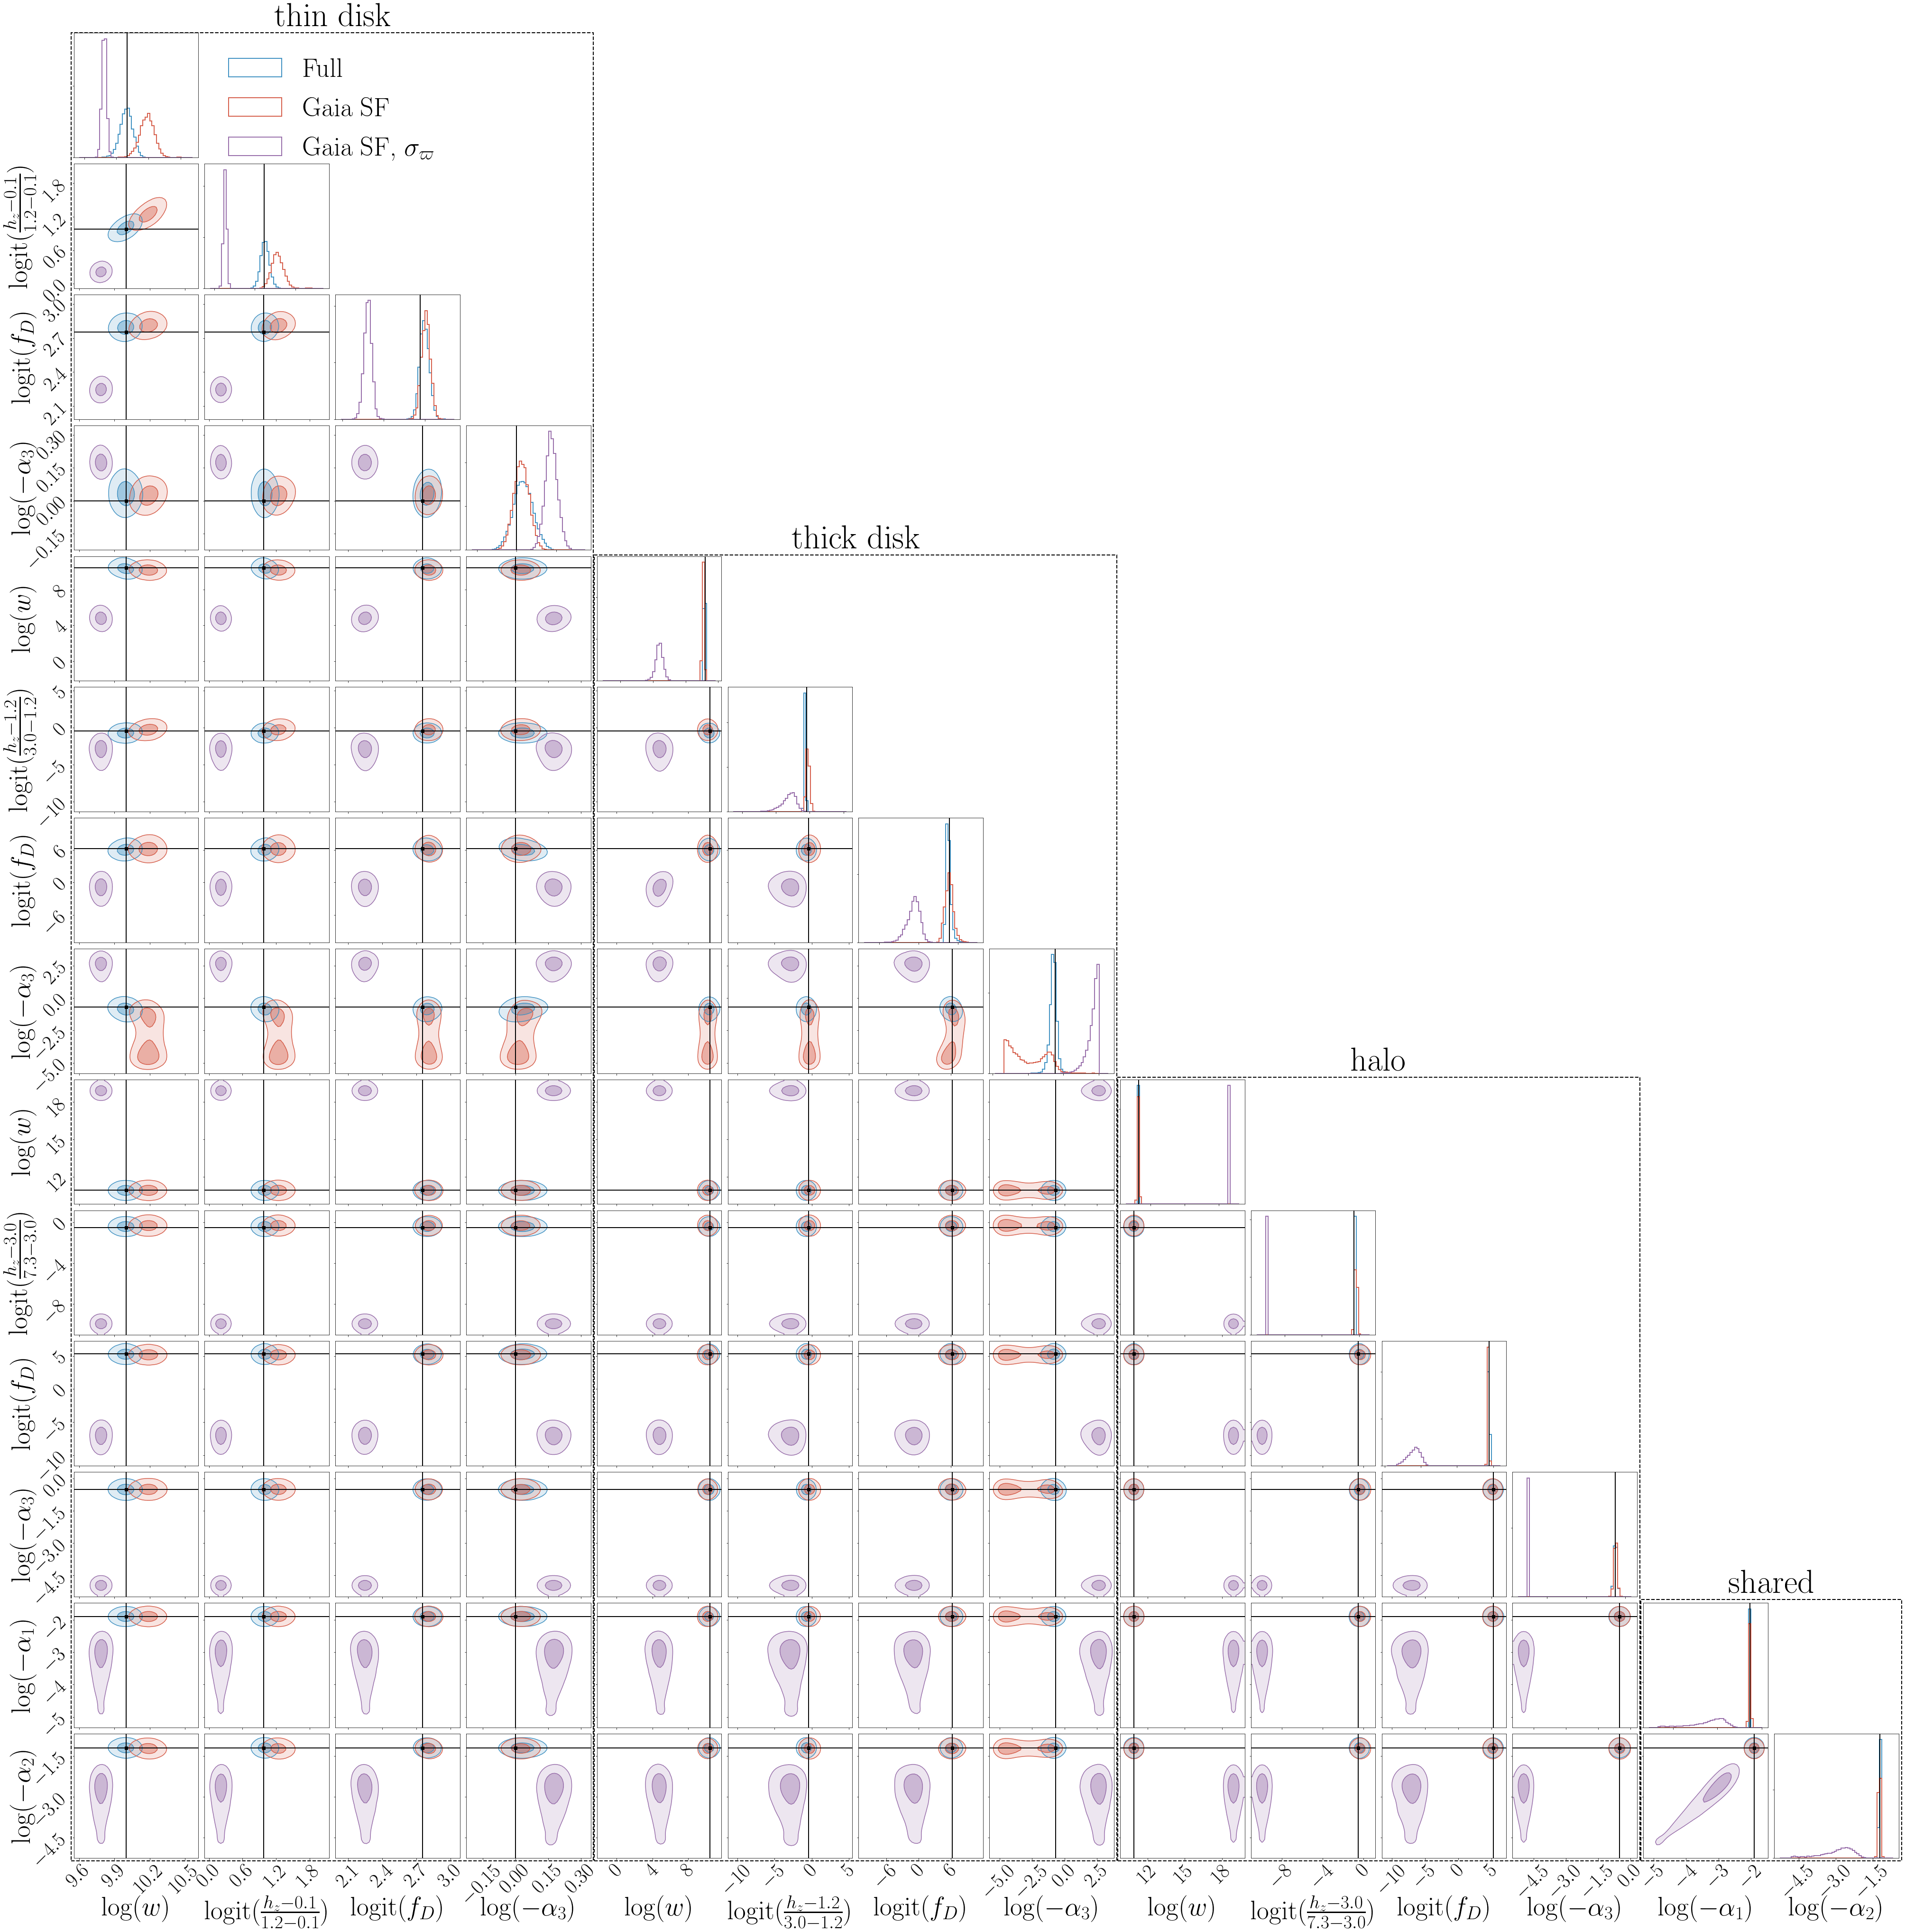

In [28]:
index = [r'Full', r'Gaia SF', r'Gaia SF, $\sigma_\varpi$']
ndim=len(true_params_f); fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners([model_full.mcmc_results['chain']['full_mcmc'],
                          model_sf.mcmc_results['chain']['sf_mcmc'],
                          model_sf_perr.mcmc_results['chain']['sf_perr_mcmc']], 
                         index=index, truths=true_params_f, truth_color='k',
                         hist_kwargs={'linewidth':2}, 
                         labels=model.get_labels(),
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model_full.free_pars[i]) for i in range(3)]+[len(model_full.free_pars['shd'])]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_corner_f.png', bbox_inches='tight', dpi=200)

In [29]:
model_full._generate_fid_pars()
functions = [model_full.fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model_full.free_pars[j]]

In [30]:
labels=[];
for cmpt in np.arange(len(model_full.components)).tolist()+['shd',]:
    for par in model_full.free_pars[cmpt]:
        labels+=[label_dict[par],]

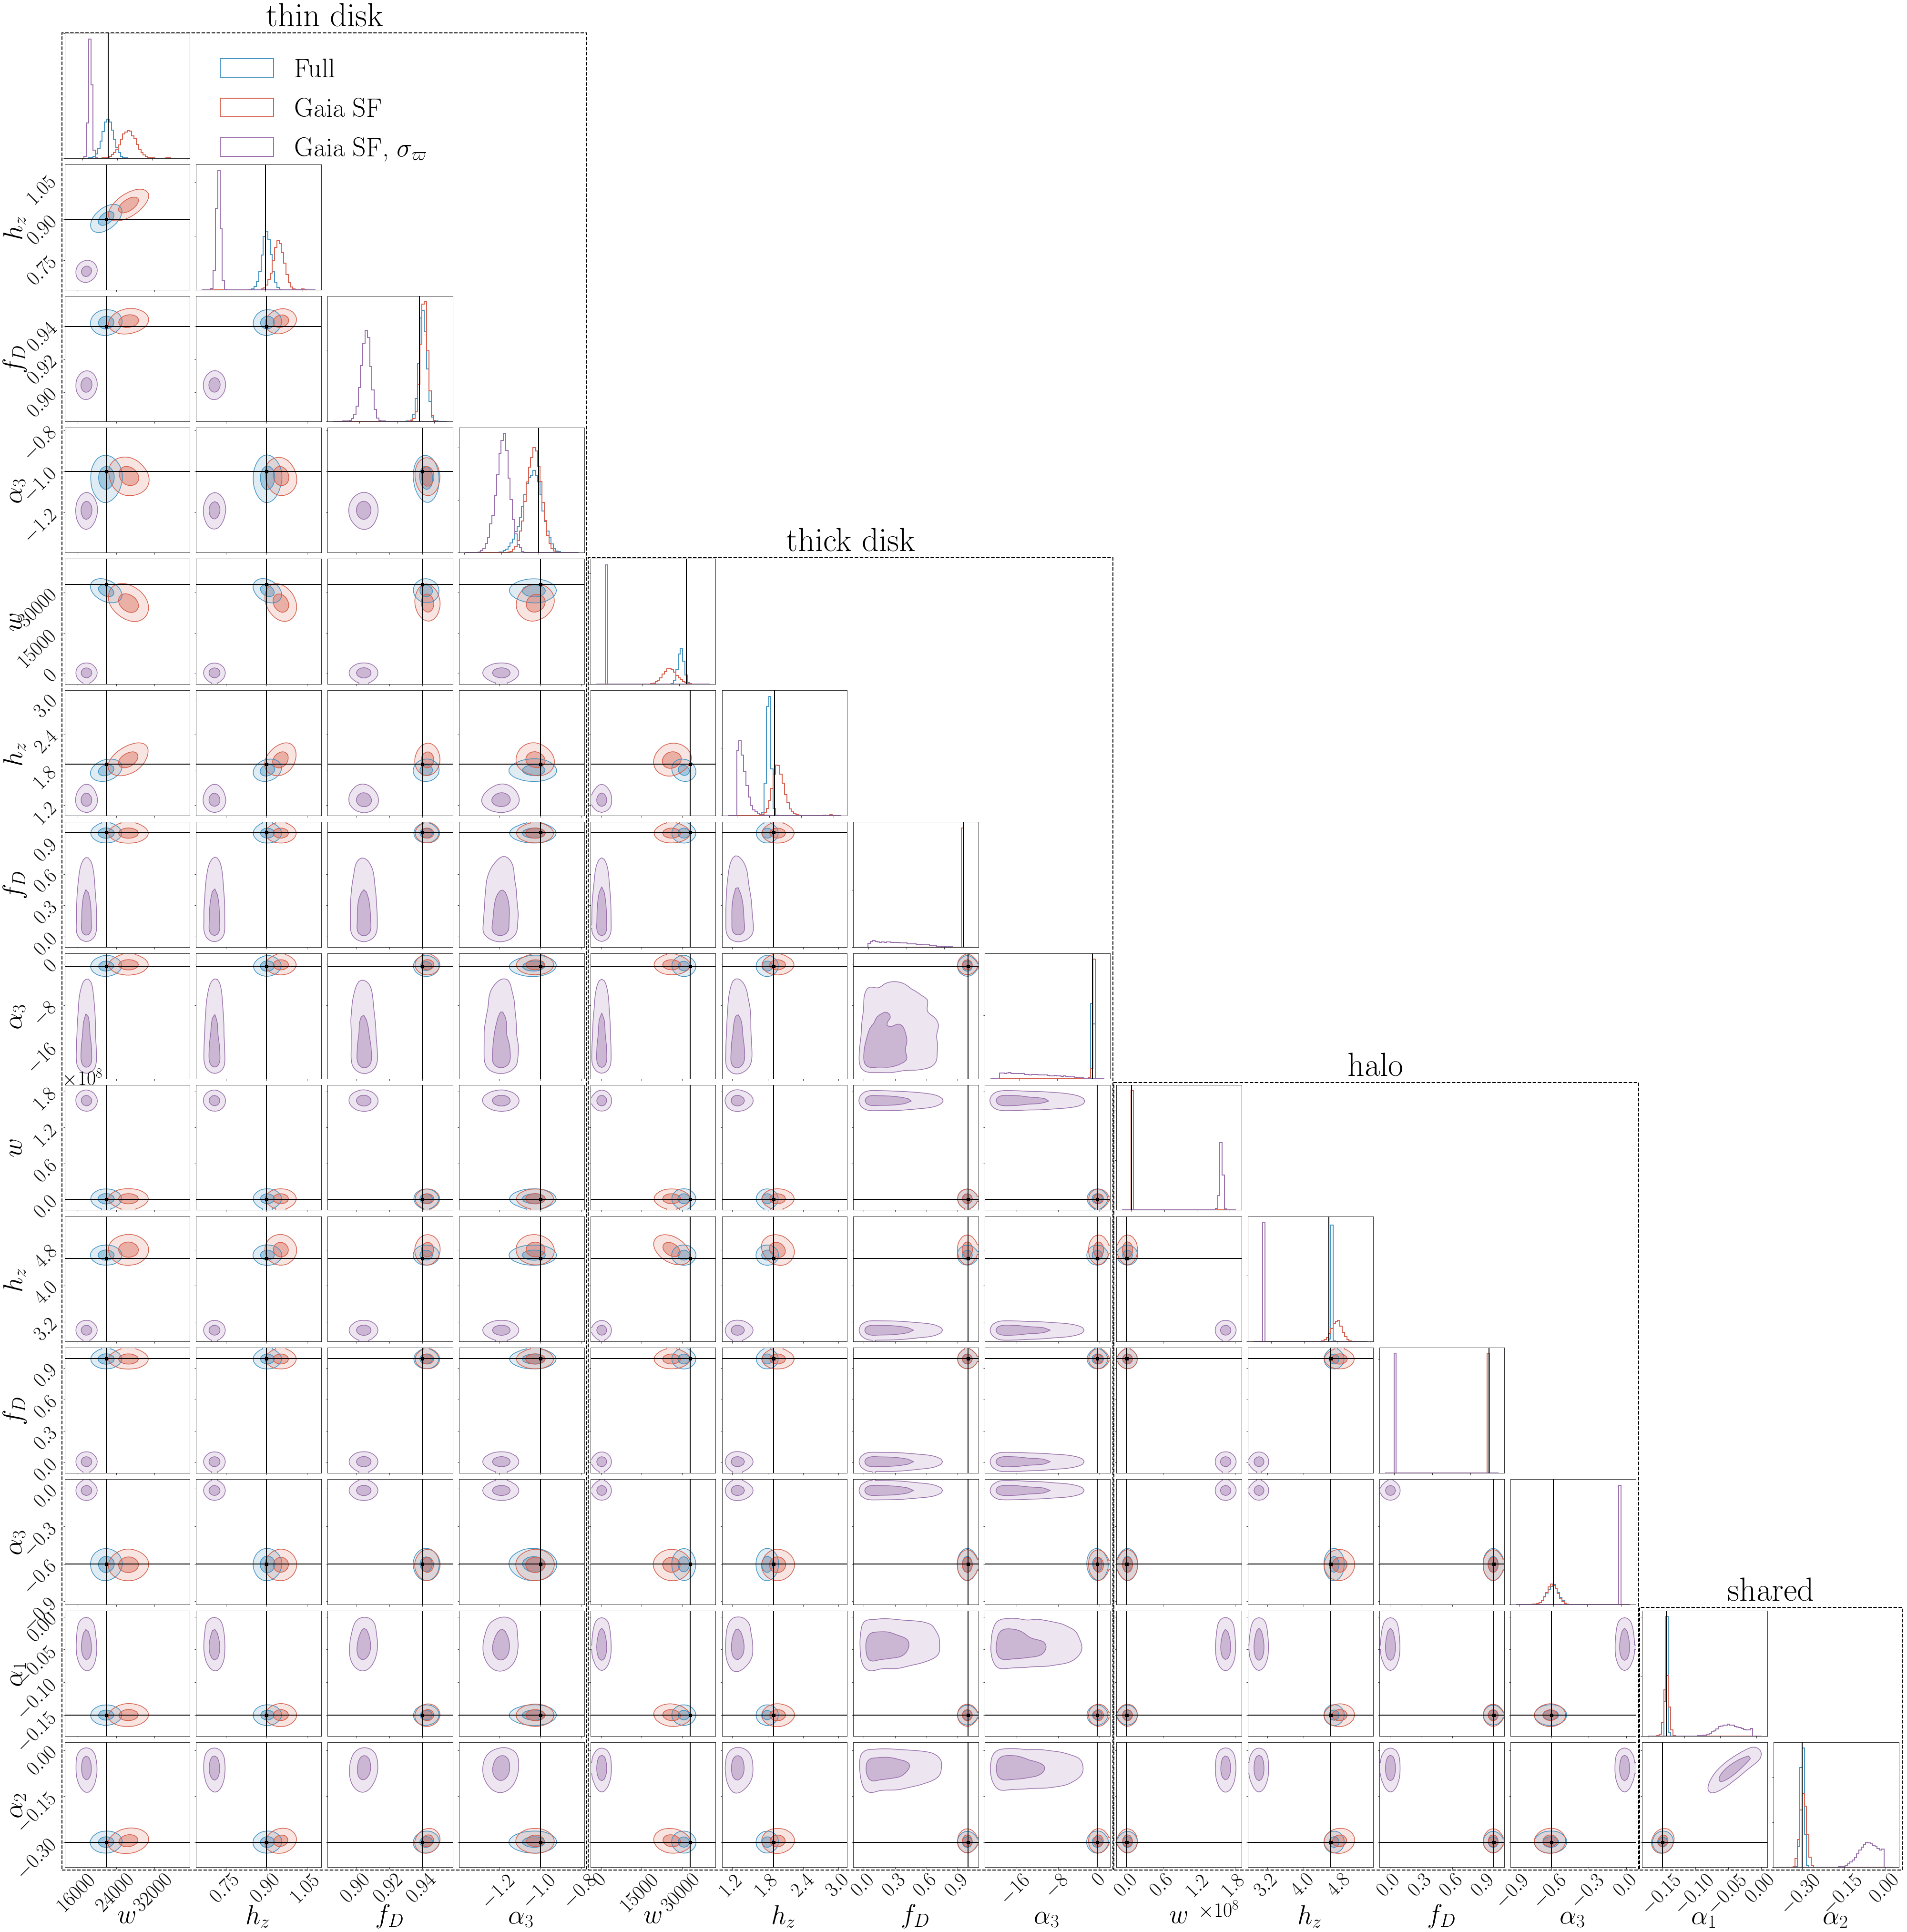

In [31]:
index = [r'Full', r'Gaia SF', r'Gaia SF, $\sigma_\varpi$']
ndim=len(true_params_f); fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners([model_full.mcmc_results['chain']['full_mcmc'].copy(),
                          model_sf.mcmc_results['chain']['sf_mcmc'].copy(),
                          model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'].copy()], 
                         index=index, truths=true_params_f, truth_color='k',
                         hist_kwargs={'linewidth':2}, 
                         labels=labels, functions=functions,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model_full.free_pars[i]) for i in range(3)]+[len(model_full.free_pars['shd'])]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)

plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_corner.png', bbox_inches='tight', dpi=200)

# Load in model fits

In [5]:
def load_hdf5_recurrent(path, hf):
    output={}

    for key in hf[path].keys():
        if isinstance(hf[os.path.join(path,key)], h5py._hl.group.Group): 
            output[int_idx(key)] = load_hdf5_recurrent(os.path.join(path,key), hf)
        else:
            output[int_idx(key)] = hf[os.path.join(path,key)][...]
            
    return output

def int_idx(i):
    if i in np.arange(10).astype(str):
        return int(i)
    else: return i

In [6]:
data = {}
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/fits_allcmpt_ncg.h'
with h5py.File(filename, 'r') as hf:
    for key in hf.keys():
        if isinstance(hf[key], h5py._hl.group.Group): 
            data[int_idx(key)] = load_hdf5_recurrent(key, hf)
        else: data[int_idx(key)] = hf[key][...]
            
for cmpt in data['param_trans'].keys():
    for par in data['param_trans'][cmpt].keys():
        data['param_trans'][cmpt][par] = data['param_trans'][cmpt][par].astype('U20').tolist()
        for i in [1,2,3,4]:
            data['param_trans'][cmpt][par][i] = float(data['param_trans'][cmpt][par][i])
for cmpt in data['free_pars'].keys():
    data['free_pars'][cmpt] = data['free_pars'][cmpt].astype('U20')

In [7]:
data.keys()

dict_keys(['fixed_pars', 'param_trans', 'lnprob', 'source_id', 'true_pars', 'free_pars', 'chain'])

# Load data

In [115]:
# Load Sample
sample = {}; true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], data['source_id'], return_indices=True)[1]
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[key]=hf['true_pars'][key][...]
        else:
            true_pars[key]={}
            for par in hf['true_pars'][key].keys():
                true_pars[key][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[str(j)]['w']*=len(sample['source_id'])

In [117]:
true_params_f=[];
true_params=[]; 
for j in range(fid_pars['ncomponents']):
    for par in fid_pars['free_pars'][j]:
        true_params_f   += [fid_pars['functions_inv'][j][par](true_pars[str(j)][par]),]
        true_params += [true_pars[str(j)][par],]
for par in fid_pars['free_pars']['shd']:
    true_params_f += [fid_pars['functions_inv']['shd'][par](true_pars[par]),]
    true_params += [true_pars[par],]
true_params_f=np.array(true_params_f)
true_params=np.array(true_params)
true_params, true_params_f

(array([ 2.0e+02,  9.0e-01,  3.0e+02,  1.9e+00,  5.0e+02,  4.6e+00,
        -1.5e-01, -3.0e-01]),
 array([ 5.29831737,  0.98082925,  5.70378247, -0.45198512,  6.2146081 ,
        -0.52324814, -1.89711998, -1.2039728 ]))

In [139]:
labels=[]; params_i = 0
for cmpt in np.arange(3).tolist()+['shd',]:
    for par in data['free_pars'][cmpt]:
        labels+=[func_labels[data['param_trans'][cmpt][par][0]](label_dict[par], *data['param_trans'][cmpt][par][1:3]),]
        params_i += 1;

# Rebuild fid_pars

In [110]:
fid_pars={'Mmax':true_pars['Mx'],  'lat_min':np.deg2rad(true_pars['theta_deg']), 'R0':true_pars['R0'],
            'w':True, 'components':['disk','disk','halo'], 'ncomponents':3,
         'free_pars':data['free_pars'], 'fixed_pars':data['fixed_pars']}

In [112]:
fid_pars['functions']={}; fid_pars['functions_inv']={}; fid_pars['jacobians']={}; bounds=[]
params_i = 0
for cmpt in np.arange(fid_pars['ncomponents']).tolist()+['shd',]:
    fid_pars['functions'][cmpt]={}; fid_pars['functions_inv'][cmpt]={}; fid_pars['jacobians'][cmpt]={}
    for par in fid_pars['free_pars'][cmpt]:
        fid_pars['functions'][cmpt][par], \
        fid_pars['functions_inv'][cmpt][par], \
        fid_pars['jacobians'][cmpt][par]=func_inv_jac[data['param_trans'][cmpt][par][0]](*data['param_trans'][cmpt][par][1:3])
        bounds.append([data['param_trans'][cmpt][par][3], data['param_trans'][cmpt][par][4]])
        params_i += 1;
bounds = np.array(bounds).T

# Plot results

(0.1, 1000)

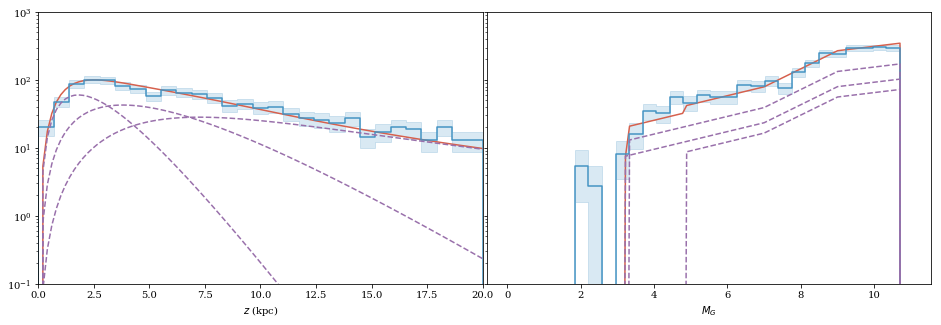

In [126]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

plt.sca(axes[0])
z_arr = np.linspace(0,20,100)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_params_f, fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['s']*sample['sinb'], np.linspace(0,20,30), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_params_f, fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_params_f, fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$M_G$')

axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_params_f, fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.subplots_adjust(wspace=0.01)

plt.ylim(0.1,1000)

In [129]:
data['chain'].keys()#['full_perr']

dict_keys(['full_perr_ncg', 'full_perr', 'prior'])

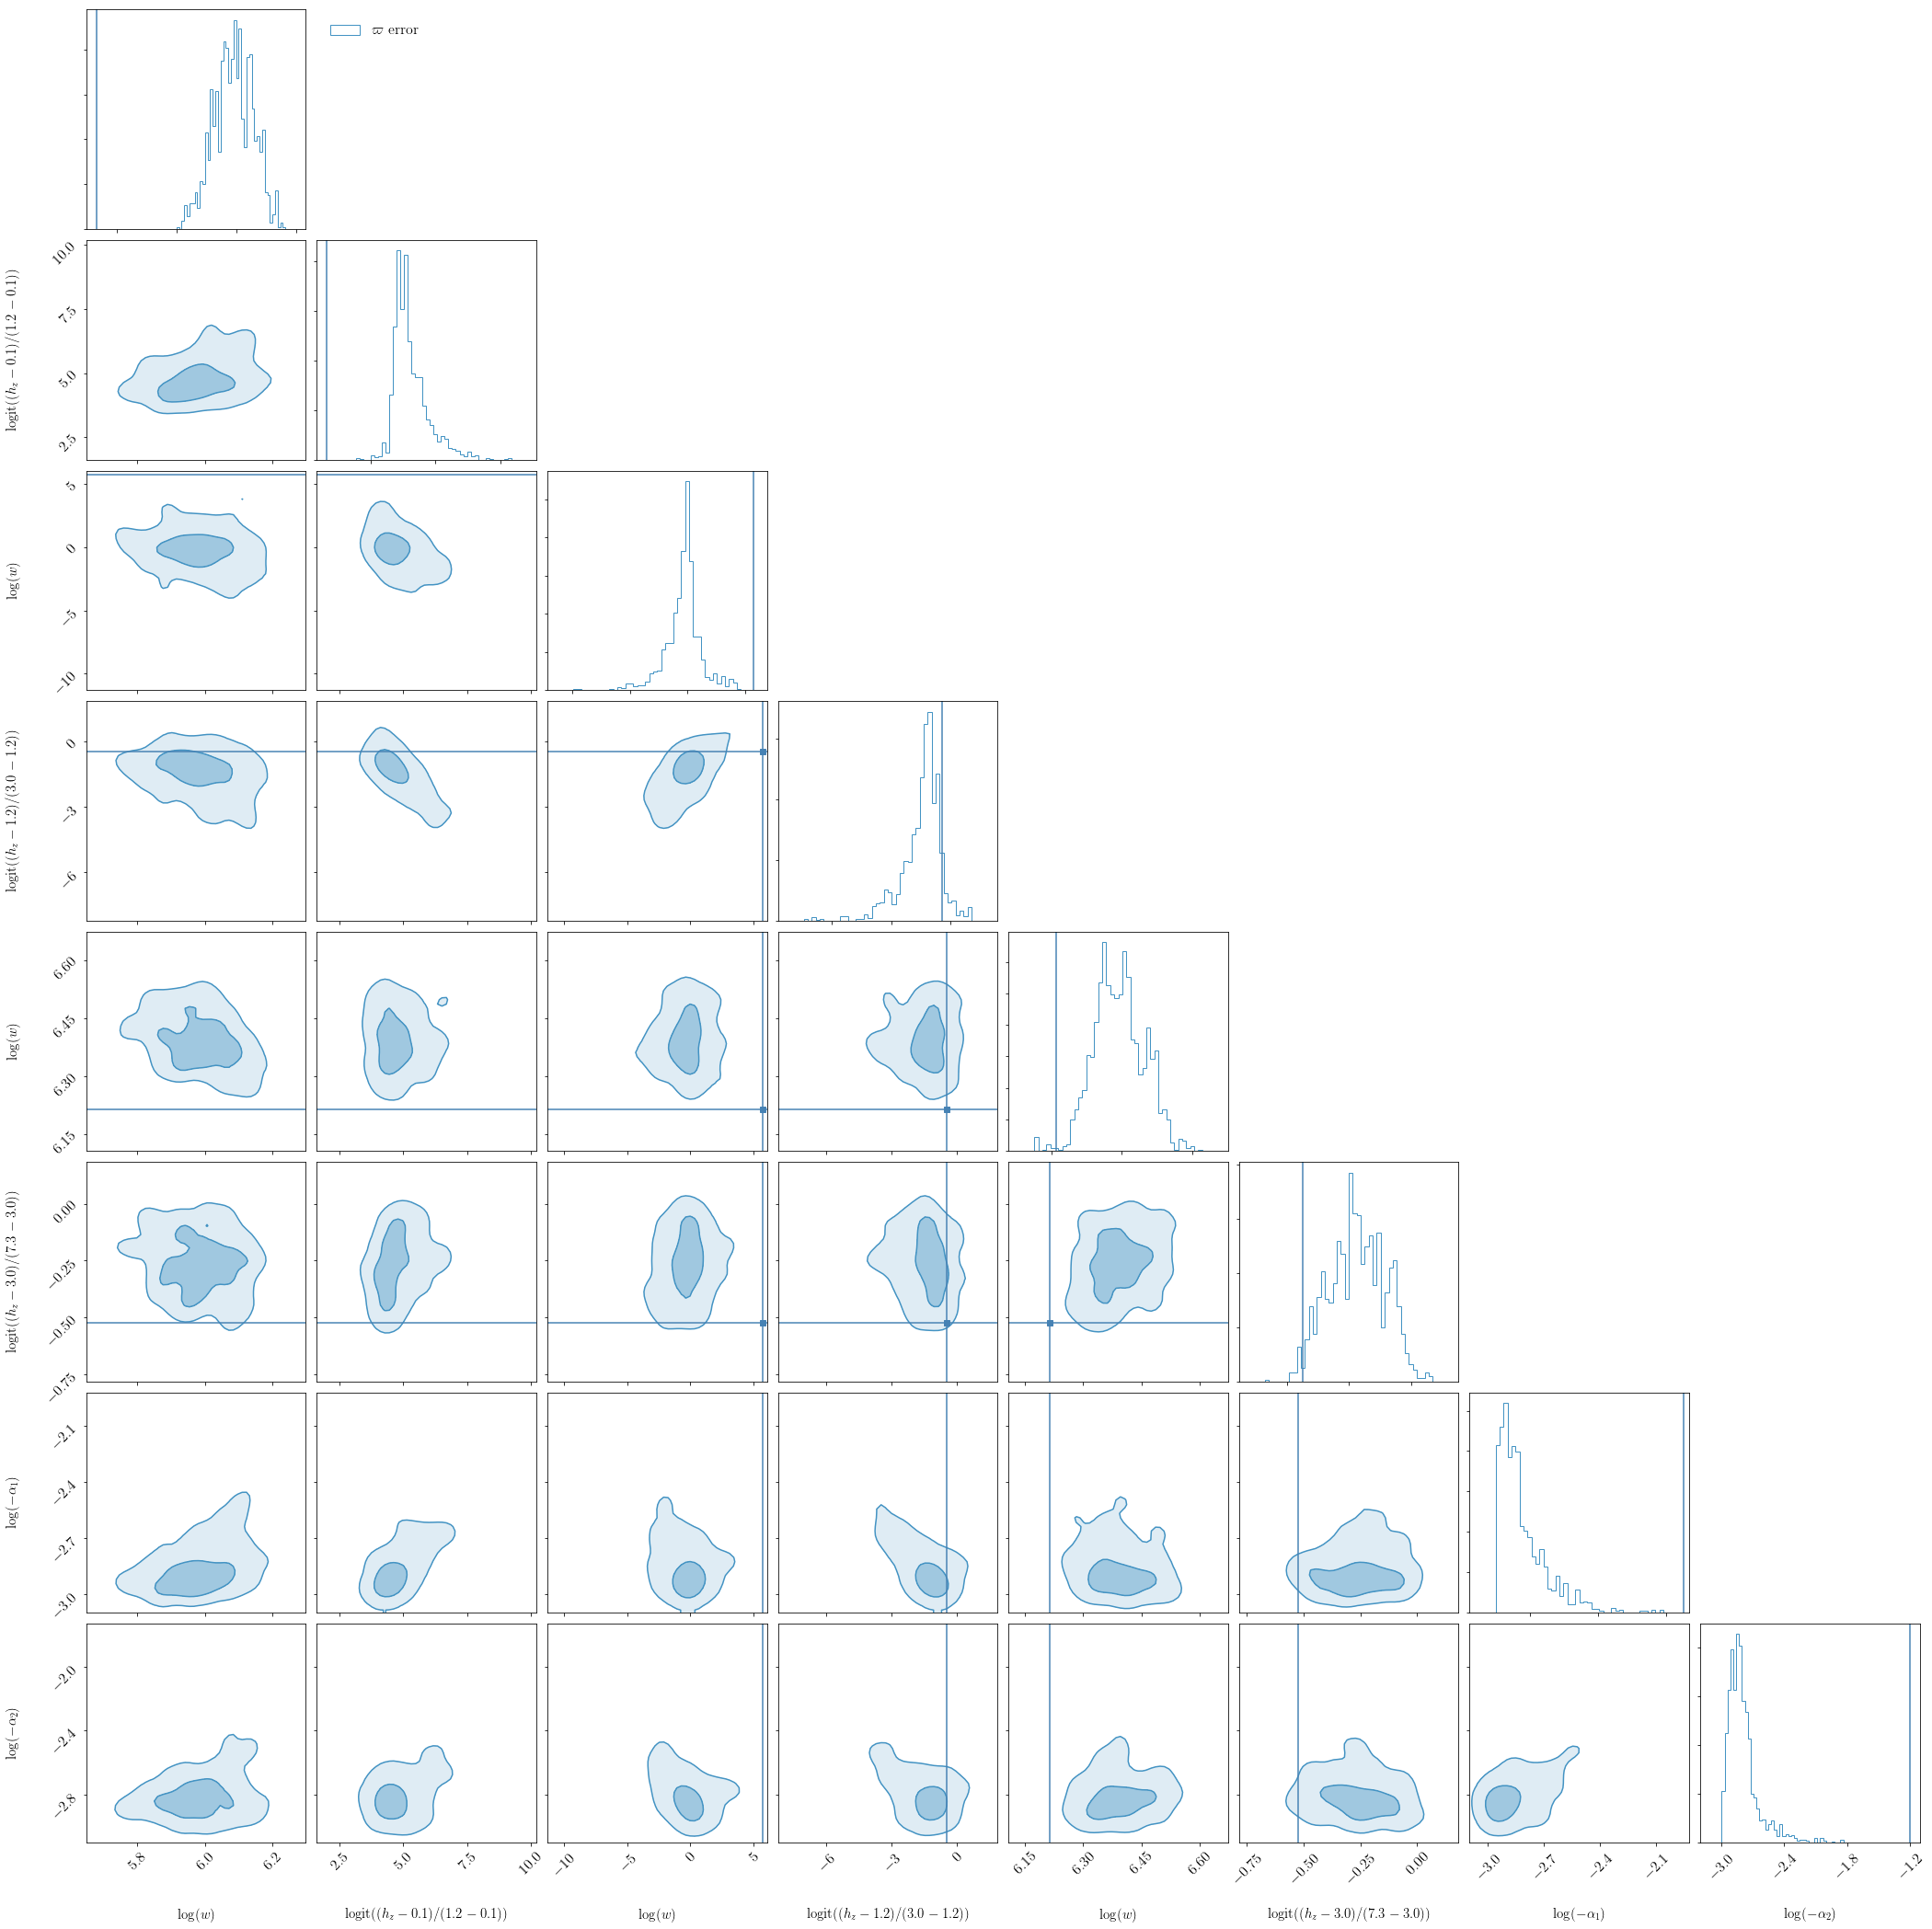

In [142]:
index = [r'$\varpi$ error']
ndim=len(true_params); fig, axes = plt.subplots(ndim,ndim, figsize=(30,30))
plotting.layered_corners([data['chain']['full_perr']], index=index, truths=true_params_f, labels=labels,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)], fig=fig, ax=axes)

In [1]:
import time

In [7]:
times = []; checkpoints = []
times.append(time.time())
checkpoints.append('start')

In [17]:
times.append(time.time())
checkpoints.append('next~')

In [18]:
times.append(time.time())
checkpoints.append('fin')

In [23]:
[print(f"Time {checkpoints[i+1]}: {(times[i+1]-times[i]):.0f}s") for i in range(len(checkpoints)-1)]

Time next~: 0s
Time fin: 0s
Time next~: 59s
Time fin: 0s


[None, None, None, None]

In [22]:
print(f"Total: {times[-1]-times[0]}")

Total: 59.39314866065979
